## This notebook combines the shock tube problem with impusive heating

## For a shock tube problem:

## $\frac{\partial \textbf{U}}{\partial t}+\frac{\partial \textbf{F}}{\partial x}=\textbf{R}$

## where:

## $\textbf{U}=\left[\begin{array}{l}
\rho \\
m \\
\hat{E}
\end{array}\right]$

## $\textbf{F(U)}=\left[\begin{array}{c}
m \\
\left(m^{2} / \rho\right)+p \\
(\hat{E}+p)m/\rho
\end{array}\right]$

## $\textbf{R}=\left[\begin{array}{l}
0 \\
0 \\
\frac{P}{A_c}q''_w
\end{array}\right]$

$\rho$ is density

m is mass flow rate

$\hat{E}$=$\rho e$ is total energy per volume

P is the perimeter of the cross section

$A_c$ is the area of the cross section

$q''_w$ is the heat from the wall per unit area


In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
cd(dirname(pwd()))
cd("src")
include("Tools.jl")
include("FiniteDifference.jl")
include("TimeMarching.jl")
include("Initial.jl")
include("Systems.jl")
include("BoundaryCondition.jl")

using ..Tools
using ..FiniteDifference
using ..TimeMarching
using ..Initial
using ..Systems
using ..BoundaryCondition
pwd()

"C:\\Users\\liyux\\github\\thermo-network\\src"

## Parameters for the RHS

In [3]:
P=1;
Ac=1; # unreal
qw=0;

righthand=[0;0;P/Ac*qw]

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

## Initialization (uniform flow)

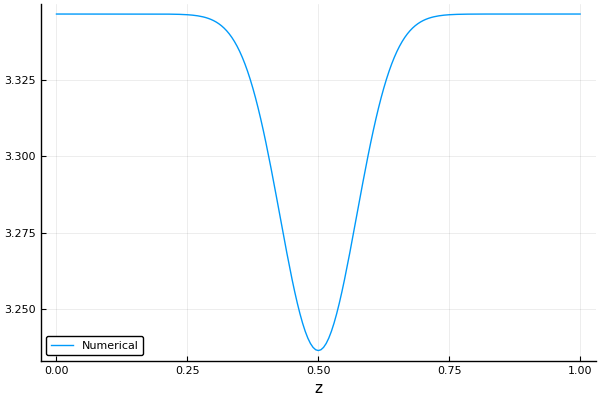

In [4]:
    # Initial spacial variables
    nx = 201   
    gamma = 1.4
    xlim = (0.0,1.0)
    Δx = (xlim[2]-xlim[1])/nx
    ux,uu=Initial.initial_one_wave(nx,xlim,gamma)
#     ux,uu=Initial.initial_sod(nx,xlim,gamma)

    # get every property from the initial uu
    uueverythinginitial=Systems.UUtoEverything(uu,gamma)
    
    # Initial time and storage arrays
    t = 0.0
    thist = []
    uhist = []

plot(ux,uueverythinginitial.c,xlabel="z",label="Numerical")

## Time Marching (with boundary condition)


In [5]:
    Δt = 0.0001

    println("Δx=",Δx);
    println("Δt=",Δt);



    #Calculation time
    tf = 0.5
    tsample = tf/500;
    T = Δt:Δt:tf

    # Push it with time!
    for ti in T
        
        # set boundary conditions
#         uu[:,1]=BoundaryCondition.set_h_boundary!(uu,uueverythinginitial)
    
        t, uu = TimeMarching.stegerwarmingrk1!(t,uu,righthand,ShockTubeSystem(gamma,Δt,Δx))
        
        # get every property from uu in every time step
        uueverything=Systems.UUtoEverything(uu,gamma)
    
    
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(thist,deepcopy(t)) : nothing
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(uueverything)) : nothing
    end
    

Δx=0.004975124378109453
Δt=1.0e-5


In [ ]:
@gif for i in 1:length(uhist)
plot(ux,uhist[i].h,xlabel="z",ylabel="variable",label="Numerical")
    end